# Importing Libraries and Datasets

In [83]:
import os
import h5py
import torch
import gdown
import shutil
import tarfile
import zipfile
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.autograd import Function,Variable
from torchvision import datasets, transforms, models
from sklearn.metrics.pairwise import euclidean_distances
from torch.utils.data import Dataset, DataLoader,ConcatDataset

## Unsupervised Domain Adaptation datasets

### Office-31 Dataset

In [2]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Copy the ZIP file from Google Drive to /content folder
zip_path = '/content/drive/My Drive/domain_adaptation_images.tar.gz'
destination_path = '/content/domain_adaptation_images.tar.gz'

# Ensure the source file exists and copy it
if os.path.exists(zip_path):
    shutil.copy(zip_path, destination_path)
    print("File copied successfully.")
else:
    print("File not found at the specified path.")


# Step 3: Extract the tar file
tar_path = destination_path
extract_path = '/content/office-31'

try:
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print(f"Extraction completed. Files extracted to: {extract_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Count the number of files in the directory (some sources mention 4110 images, others mention 4652 )
!find /content/office-31 -type f | wc -l

Mounted at /content/drive
File copied successfully.
Extraction completed. Files extracted to: /content/office-31
4110


In [3]:
# Define transformations for the dataset (resize, ToTensor, and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (common for pretrained models)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images

])

# Define dataset paths
root_path = '/content/office-31'

# Paths for each domain (amazon, dslr, webcam)
amazon_path = os.path.join(root_path, 'amazon/images')
dslr_path = os.path.join(root_path, 'dslr/images')
webcam_path = os.path.join(root_path, 'webcam/images')

# Load the datasets using ImageFolder
amazon_dataset = datasets.ImageFolder(root=amazon_path, transform=transform)
dslr_dataset = datasets.ImageFolder(root=dslr_path, transform=transform)
webcam_dataset = datasets.ImageFolder(root=webcam_path, transform=transform)

# Create DataLoader for each domain
amazon_loader = DataLoader(amazon_dataset, batch_size=32, shuffle=True)
dslr_loader = DataLoader(dslr_dataset, batch_size=32, shuffle=True)
webcam_loader = DataLoader(webcam_dataset, batch_size=32, shuffle=True)

# Check sizes of the datasets
print(f"Amazon dataset size: {len(amazon_loader.dataset)}")
print(f"DSLR dataset size: {len(dslr_loader.dataset)}")
print(f"Webcam dataset size: {len(webcam_loader.dataset)}")

office31_classes = [
    "back_pack", "bike", "bike_helmet", "bookcase", "bottle", "calculator", "desk_chair", "desk_lamp",
    "desktop_computer", "file_cabinet", "headphones", "keyboard", "laptop_computer", "letter_tray",
    "mobile_phone", "monitor", "mouse", "mug", "paper_notebook", "pen", "phone", "printer", "projector", "punchers",
    "ring_binder", "ruler", "scissors", "speaker", "stapler", "tape_dispenser", "trash_can"
]

Amazon dataset size: 2817
DSLR dataset size: 498
Webcam dataset size: 795


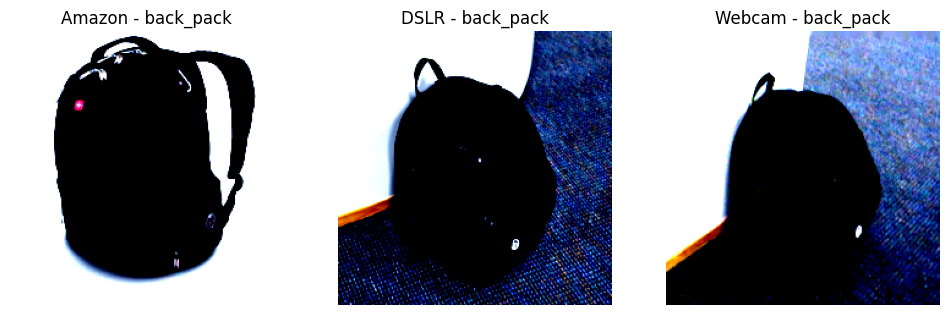

In [ ]:
def get_first_image_from_class(dataset, class_name):
    # Get the class index
    class_idx = dataset.class_to_idx[class_name]

    # Iterate through dataset to find the first image in the specified class
    for img, label in dataset:
        if label == class_idx:
            return img

# Get the first 'back_pack' image from each domain
amazon_image = get_first_image_from_class(amazon_dataset, 'back_pack')
dslr_image = get_first_image_from_class(dslr_dataset, 'back_pack')
webcam_image = get_first_image_from_class(webcam_dataset, 'back_pack')

# Convert tensor images back to numpy arrays for visualization
amazon_image = amazon_image.permute(1, 2, 0).numpy()
dslr_image = dslr_image.permute(1, 2, 0).numpy()
webcam_image = webcam_image.permute(1, 2, 0).numpy()

# Plot the images
plt.figure(figsize=(12, 4))

# Plot Amazon image
plt.subplot(1, 3, 1)
plt.imshow(amazon_image)
plt.title("Amazon - back_pack")
plt.axis('off')

# Plot DSLR image
plt.subplot(1, 3, 2)
plt.imshow(dslr_image)
plt.title("DSLR - back_pack")
plt.axis('off')

# Plot Webcam image
plt.subplot(1, 3, 3)
plt.imshow(webcam_image)
plt.title("Webcam - back_pack")
plt.axis('off')

plt.show()

### Digits Datasets

In [76]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Copy the ZIP file from Google Drive to /content folder
zip_path = '/content/drive/My Drive/USPS/USPS.h5'
destination_path = '/content/USPS.h5'

# Ensure the source file exists and copy it
if os.path.exists(zip_path):
    shutil.copy(zip_path, destination_path)
    print("File copied successfully.")
else:
    print("File not found at the specified path.")


# Load USPS dataset from HDF5 file
with h5py.File('/content/USPS.h5', 'r') as f:
    # Check the structure of the HDF5 file to inspect datasets
    print(f.keys())  # Display the keys in the HDF5 file (you may need to explore this to identify datasets)
    print(np.array(f['train']['data'].shape), np.array(f['train']['target'].shape))
    print(np.array(f['test']['data'].shape), np.array(f['test']['target'].shape))

    # Extract training and test data
    train_images = np.array(f['train']['data'])  # Assumed key for training data
    train_labels = np.array(f['train']['target'])  # Assumed key for training labels
    test_images = np.array(f['test']['data'])  # Assumed key for test data
    test_labels = np.array(f['test']['target'])  # Assumed key for test labels

# Convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)


transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

# Create custom dataset class for USPS
class USPSDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # List of images (PIL images or numpy arrays)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.reshape(1, 16, 16)

        # print(type(image),type(label),image.shape, label.shape, label)

        return image, label

# Create data loaders for training and testing
usps_train_dataset = USPSDataset(train_images, train_labels, transform=transform)
usps_test_dataset = USPSDataset(test_images, test_labels, transform=transform)

usps_train_loader = DataLoader(usps_train_dataset, batch_size=64, shuffle=True)
usps_test_loader = DataLoader(usps_test_dataset, batch_size=64, shuffle=False)

# Check the length of the datasets
print(f"USPS Train dataset size: {len(usps_train_loader.dataset)}")
print(f"USPS Test dataset size: {len(usps_test_loader.dataset)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File copied successfully.
<KeysViewHDF5 ['test', 'train']>
[7291  256] [7291]
[2007  256] [2007]
USPS Train dataset size: 7291
USPS Test dataset size: 2007


In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB images to [-1, 1]
])

# Load the SVHN dataset (train and test sets)
svhn_train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Create data loaders
svhn_train_loader = torch.utils.data.DataLoader(svhn_train_dataset, batch_size=64, shuffle=True)
svhn_test_loader = torch.utils.data.DataLoader(svhn_test_dataset, batch_size=64, shuffle=False)

# Check dataset size
print(f"SVHN Train dataset size: {len(svhn_train_loader.dataset)}")
print(f"SVHN Test dataset size: {len(svhn_test_loader.dataset)}")

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))  # Normalizes to [-1, 1]
])

# Load MNIST dataset
mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

# Check dataset size
print(f"MNIST Train dataset size: {len(mnist_train_loader.dataset)}")
print(f"MNIST Test dataset size: {len(mnist_test_loader.dataset)}")

100%|██████████| 182M/182M [01:33<00:00, 1.95MB/s]


100%|██████████| 64.3M/64.3M [00:32<00:00, 1.98MB/s]


SVHN Train dataset size: 73257
SVHN Test dataset size: 26032
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.79MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

MNIST Train dataset size: 60000
MNIST Test dataset size: 10000


In [78]:
common_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((16, 16)),               # Resize to 224x224
    transforms.ToTensor()                        # Convert to tensor
])

mnist_train_dataset.transform = common_transforms
mnist_test_dataset.transform = common_transforms

svhn_train_dataset.transform = common_transforms
svhn_test_dataset.transform = common_transforms

# Combine the train and test datasets
usps_combined_dataset = ConcatDataset([usps_train_dataset, usps_test_dataset])
mnist_combined_dataset = ConcatDataset([mnist_train_dataset, mnist_test_dataset])
svhn_combined_dataset = ConcatDataset([svhn_train_dataset, svhn_test_dataset])

# Create new DataLoaders
usps_loader = DataLoader(
    usps_combined_dataset,
    batch_size=32,  # Choose an appropriate batch size
    shuffle=True,   # Shuffle for combined dataset
    num_workers=2   # Number of workers for data loading
)

mnist_loader = DataLoader(
    mnist_combined_dataset,
    batch_size=32,  # Choose an appropriate batch size
    shuffle=True,   # Shuffle for combined dataset
    num_workers=2   # Number of workers for data loading
)

svhn_loader = DataLoader(
    svhn_combined_dataset,
    batch_size=32,  # Choose an appropriate batch size
    shuffle=True,   # Shuffle for combined dataset
    num_workers=2   # Number of workers for data loading
)

print(f"USPS combined dataset size: {len(usps_loader.dataset)}")
print(f"MNIST combined dataset size: {len(mnist_loader.dataset)}")
print(f"SVHN combined dataset size: {len(svhn_loader.dataset)}")

USPS combined dataset size: 9298
MNIST combined dataset size: 70000
SVHN combined dataset size: 99289


In [79]:
# Print the shape of one batch from MNIST loader
mnist_batch = next(iter(mnist_loader))
mnist_images, mnist_labels = mnist_batch
print(f"MNIST batch image shape: {mnist_images.shape}, label shape: {mnist_labels.shape}")

# Print the shape of one batch from SVHN loader
svhn_batch = next(iter(svhn_loader))
svhn_images, svhn_labels = svhn_batch
print(f"SVHN batch image shape: {svhn_images.shape}, label shape: {svhn_labels.shape}")

# Print the shape of one batch from USPS loader
usps_batch = next(iter(usps_loader))
usps_images, usps_labels = usps_batch
print(f"USPS batch image shape: {usps_images.shape}, label shape: {usps_labels.shape}")

MNIST batch image shape: torch.Size([32, 1, 16, 16]), label shape: torch.Size([32])
SVHN batch image shape: torch.Size([32, 1, 16, 16]), label shape: torch.Size([32])
USPS batch image shape: torch.Size([32, 1, 16, 16]), label shape: torch.Size([32])


<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([64, 1, 16, 16]) torch.Size([64])
<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([64, 1, 28, 28]) torch.Size([64])
<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) torch.Size([64])


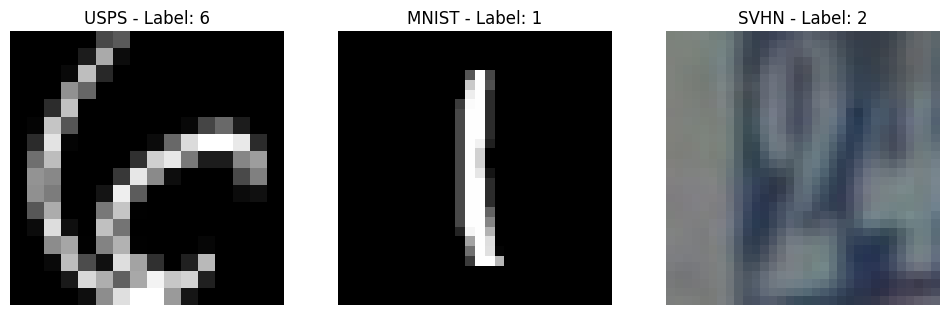

In [ ]:
# Function to get a sample image from a DataLoader
def get_sample_image(loader):
    # Get a batch from the loader
    data_iter = iter(loader)
    # print(next(data_iter))
    images, labels = next(data_iter)
    print(type(images),type(labels), images.shape, labels.shape)

#                                   USPS,  MNIST, SVHN
# <class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([64, 1, 16, 16]) torch.Size([64])
# <class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([64, 1, 28, 28]) torch.Size([64])
# <class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) torch.Size([64])

    # Get the first image from the batch
    return images[0], labels[0]

# Get one sample image from each loader
usps_image, usps_label = get_sample_image(usps_train_loader)
mnist_image, mnist_label = get_sample_image(mnist_train_loader)
svhn_image, svhn_label = get_sample_image(svhn_train_loader)

# Convert the images to numpy arrays for visualization (assuming they are in tensor form)
usps_image = usps_image.squeeze().cpu().numpy()  # Remove any extra dimensions
mnist_image = mnist_image.squeeze().cpu().numpy()
svhn_image = svhn_image.squeeze().cpu().numpy()

# Plot the images in subplots
plt.figure(figsize=(12, 4))

# Plot USPS image
plt.subplot(1, 3, 1)
plt.imshow(usps_image, cmap='gray')
plt.title(f"USPS - Label: {usps_label.item()}")
plt.axis('off')

# Plot MNIST image
plt.subplot(1, 3, 2)
plt.imshow(mnist_image, cmap='gray')
plt.title(f"MNIST - Label: {mnist_label.item()}")
plt.axis('off')

# Plot SVHN image
plt.subplot(1, 3, 3)
plt.imshow(svhn_image.transpose(1, 2, 0))  # SVHN images are RGB, so need to transpose
plt.title(f"SVHN - Label: {svhn_label.item()}")
plt.axis('off')

plt.show()


### **Optional**  ... Office-Home Dataset

In [ ]:
# Step 1: Mount Google Drive
# drive.mount('/content/drive')

# Step 2: Copy the ZIP file from Google Drive to /content folder
zip_path = '/content/drive/My Drive/OfficeHomeDataset_10072016.zip'
destination_path = '/content/OfficeHomeDataset_10072016.zip'

# Ensure the source file exists and copy it
if os.path.exists(zip_path):
    shutil.copy(zip_path, destination_path)
    print("File copied successfully.")
else:
    print("File not found at the specified path.")

# Step 3: Unzip the file to /content folder
with zipfile.ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("ZIP file extracted.")

File copied successfully.
ZIP file extracted.


In [ ]:
# Count the number of files in the directory
!find /content/OfficeHomeDataset_10072016 -type f | wc -l

15590


# UDA

In [6]:
# test_split_ratio = 0.2
# # Split datasets into train and test
# amazon_train_size = int((1 - test_split_ratio) * len(amazon_dataset))
# amazon_test_size = len(amazon_dataset) - amazon_train_size
# amazon_train_dataset, amazon_test_dataset = random_split(amazon_dataset, [amazon_train_size, amazon_test_size])

# webcam_train_size = int((1 - test_split_ratio) * len(webcam_dataset))
# webcam_test_size = len(webcam_dataset) - webcam_train_size
# webcam_train_dataset, webcam_test_dataset = random_split(webcam_dataset, [webcam_train_size, webcam_test_size])

# # Create DataLoaders
# amazon_train_loader = DataLoader(amazon_train_dataset, batch_size=office31_batchsize, shuffle=True)
# amazon_test_loader = DataLoader(amazon_test_dataset, batch_size=office31_batchsize, shuffle=False)

# webcam_train_loader = DataLoader(webcam_train_dataset, batch_size=office31_batchsize, shuffle=True)
# webcam_test_loader = DataLoader(webcam_test_dataset, batch_size=office31_batchsize, shuffle=False)

In [114]:
num_epochs = 1         # Number of epochs
learning_rate = 0.001   # Learning rate for SGD  0.001 gives 52% test acc (other rates gives worse, )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
office31_batchsize = 32
digits_batchsize = 32

office31_combos = [                       #(train_loader, test_loader)
    (amazon_loader, webcam_loader),
    (amazon_loader, dslr_loader),
    (webcam_loader, amazon_loader),
    (webcam_loader, dslr_loader),
    (dslr_loader,amazon_loader),
    (dslr_loader, webcam_loader)
]

office31_acc_dict = {
    ('A','W'):0 ,
    ('A','D'):0 ,
    ('W','A'):0 ,
    ('W','D'):0 ,
    ('D','A'):0 ,
    ('D','W'):0
  }

office31_combo_accs = {
  'resnet': office31_acc_dict,
  'dan': office31_acc_dict,
  'dann': office31_acc_dict
}
office31_combo_names = list(office31_acc_dict.keys())

office31_accs = []

In [22]:
def init_resnet(num_classes=31):
  resnet50 = models.resnet50(pretrained=True)
  resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
  # print(resnet50)
  return resnet50


def finetune_baseline_model(model, source_loader, device, learning_rate=0.001, num_epochs=10):

    print("Finetuning ResNet baseline model to source domain")
    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Fine-tune the model
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in source_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print epoch statistics
        epoch_loss = running_loss / len(source_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")


    return model

def evaluate_accuracy(model, test_loader, device, model_name):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            if model_name == 'DAN':
              _, outputs , _ = model(inputs)
            elif model_name == 'ResNet':
              outputs = model(inputs)
            elif model_name == 'DANN':
              pass
            else:
              raise ValueError("Invalid model name. Choose from 'DAN', 'ResNet', or 'DANN'.")

            # If the model outputs logits, apply softmax to get probabilities
            _, predicted = torch.max(outputs, 1)

            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"{model_name} Model Accuracy on the test set: {accuracy:.2f}%")
    return accuracy

resnet = init_resnet(num_classes=31).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [108]:
def visualize_feature_distributions(model, source_loader, target_loader, device):
    def get_features(model, data):
        _, features, _ = model(data)
        return features.cpu().numpy()

    model.eval()
    source_features, source_labels = [], []
    target_features, target_labels = [], []

    # Extract source features
    with torch.no_grad():
        for data, labels in source_loader:
            data = data.to(device)
            features = get_features(model, data)
            source_features.append(features)
            source_labels.extend(labels.numpy())

    # Extract target features
    with torch.no_grad():
        for data, labels in target_loader:
            data = data.to(device)
            features = get_features(model, data)
            target_features.append(features)
            target_labels.extend(labels.numpy())

    # Combine and reduce dimensions using t-SNE
    all_features = np.concatenate([np.vstack(source_features), np.vstack(target_features)], axis=0)
    all_labels = np.array(source_labels + target_labels)
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(all_features)

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(
        reduced_features[:len(source_labels), 0], reduced_features[:len(source_labels), 1],
        c=source_labels, cmap='viridis', label='Source Domain', alpha=0.6
    )
    plt.scatter(
        reduced_features[len(source_labels):, 0], reduced_features[len(source_labels):, 1],
        c=target_labels, cmap='plasma', label='Target Domain', alpha=0.6
    )
    plt.title("t-SNE Visualization of Feature Distributions for DAN ")
    plt.legend()
    plt.show()


# source_train_loader, target_train_loader = office31_combos[len(office31_combos)-1]
# visualize_feature_distributions(trained_dan_model, source_train_loader, target_train_loader, device)

 ---------------------------------------------Running A to W adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.9644, Source Accuracy: 0.0509, Target Accuracy: 0.0415
Epoch [2/10], Loss: 0.6385, Source Accuracy: 0.1454, Target Accuracy: 0.0325
Epoch [3/10], Loss: 0.4745, Source Accuracy: 0.1724, Target Accuracy: 0.0315
Epoch [4/10], Loss: 0.4393, Source Accuracy: 0.1886, Target Accuracy: 0.0365
Epoch [5/10], Loss: 0.3653, Source Accuracy: 0.2040, Target Accuracy: 0.0227
Epoch [6/10], Loss: 0.2989, Source Accuracy: 0.2240, Target Accuracy: 0.0317
Epoch [7/10], Loss: 0.2942, Source Accuracy: 0.2265, Target Accuracy: 0.0302
Epoch [8/10], Loss: 0.2424, Source Accuracy: 0.2367, Target Accuracy: 0.0292
Epoch [9/10], Loss: 0.2276, Source Accuracy: 0.2433, Target Accuracy: 0.0405
Epoch [10/10], Loss: 0.2333, Source Accuracy: 0.2430, Target Accuracy: 0.0275
DAN Model Accuracy on the test set: 51.45%


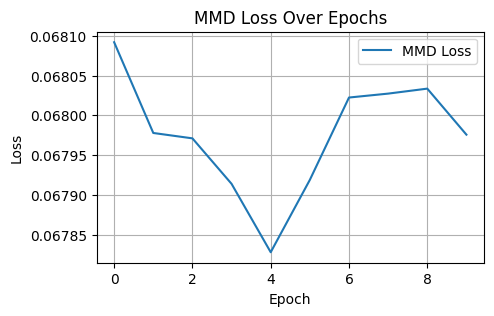

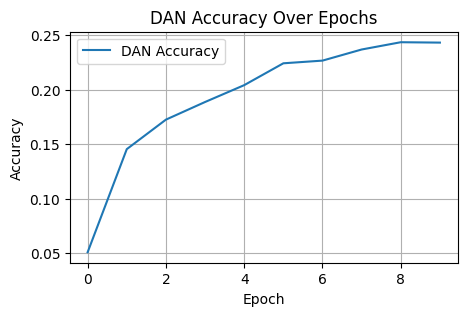

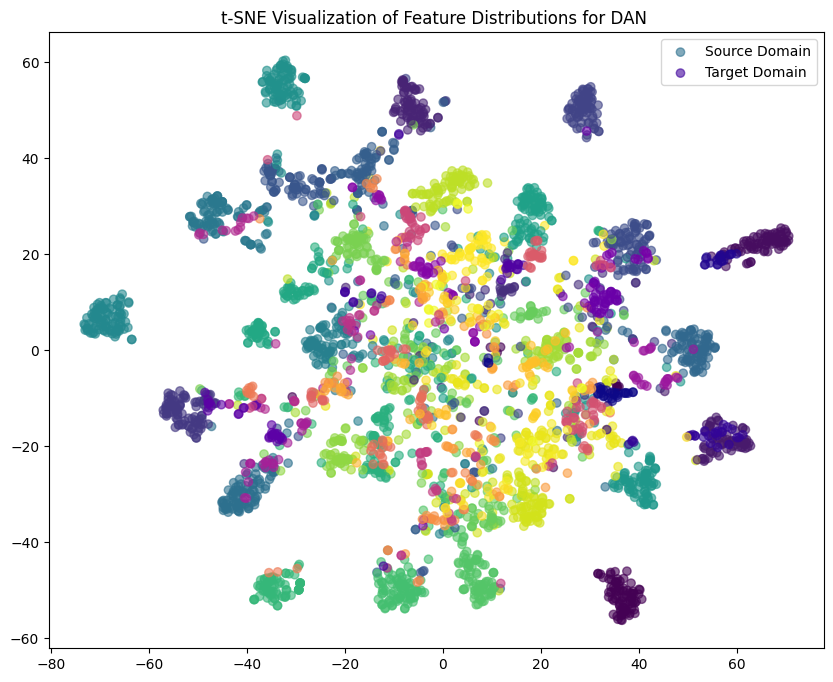

 ---------------------------------------------Running A to D adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.6663, Source Accuracy: 0.0172, Target Accuracy: 0.0234
Epoch [2/10], Loss: 0.5349, Source Accuracy: 0.0569, Target Accuracy: 0.0347
Epoch [3/10], Loss: 0.4015, Source Accuracy: 0.0885, Target Accuracy: 0.0417
Epoch [4/10], Loss: 0.3472, Source Accuracy: 0.1018, Target Accuracy: 0.0430
Epoch [5/10], Loss: 0.3060, Source Accuracy: 0.1159, Target Accuracy: 0.0484
Epoch [6/10], Loss: 0.2633, Source Accuracy: 0.1268, Target Accuracy: 0.0352
Epoch [7/10], Loss: 0.2525, Source Accuracy: 0.1254, Target Accuracy: 0.0421
Epoch [8/10], Loss: 0.2218, Source Accuracy: 0.1369, Target Accuracy: 0.0312
Epoch [9/10], Loss: 0.1964, Source Accuracy: 0.1408, Target Accuracy: 0.0401
Epoch [10/10], Loss: 0.1915, Source Accuracy: 0.1436, Target Accuracy: 0.0523
DAN Model Accuracy on the test set: 50.60%


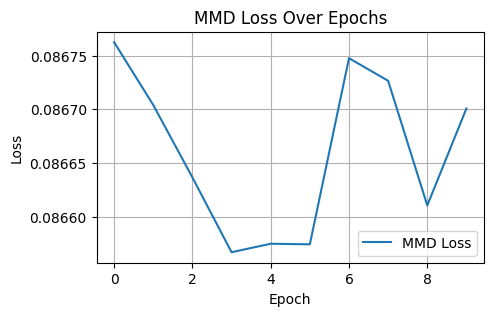

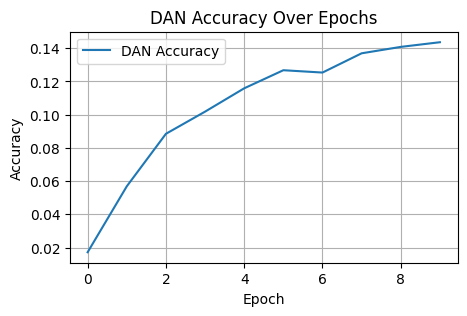

 ---------------------------------------------Running W to A adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 3.4481, Source Accuracy: 0.1760, Target Accuracy: 0.0084
Epoch [2/10], Loss: 1.6849, Source Accuracy: 0.6893, Target Accuracy: 0.0091
Epoch [3/10], Loss: 0.7266, Source Accuracy: 0.8678, Target Accuracy: 0.0084
Epoch [4/10], Loss: 0.6055, Source Accuracy: 0.9295, Target Accuracy: 0.0060
Epoch [5/10], Loss: 0.4208, Source Accuracy: 0.9725, Target Accuracy: 0.0119
Epoch [6/10], Loss: 0.3598, Source Accuracy: 0.9912, Target Accuracy: 0.0112
Epoch [7/10], Loss: 0.3300, Source Accuracy: 0.9962, Target Accuracy: 0.0105
Epoch [8/10], Loss: 0.3271, Source Accuracy: 0.9988, Target Accuracy: 0.0098
Epoch [9/10], Loss: 0.3237, Source Accuracy: 1.0000, Target Accuracy: 0.0077
Epoch [10/10], Loss: 0.3188, Source Accuracy: 0.9988, Target Accuracy: 0.0091
DAN Model Accuracy on the test set: 39.26%


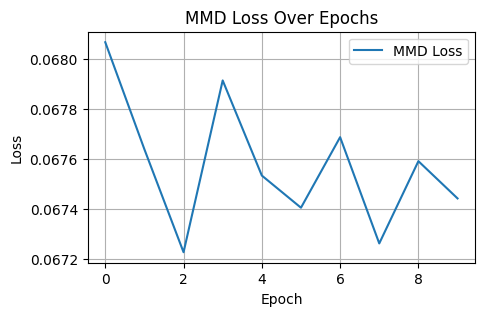

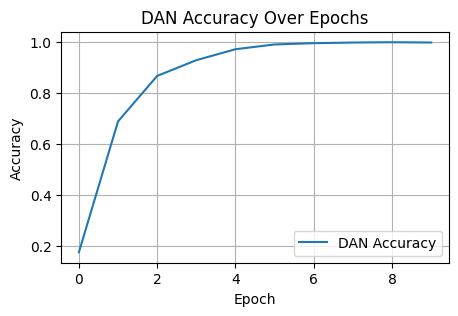

 ---------------------------------------------Running W to D adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 2.3476, Source Accuracy: 0.0587, Target Accuracy: 0.0293
Epoch [2/10], Loss: 1.7836, Source Accuracy: 0.2487, Target Accuracy: 0.0332
Epoch [3/10], Loss: 0.9441, Source Accuracy: 0.4562, Target Accuracy: 0.0464
Epoch [4/10], Loss: 0.6167, Source Accuracy: 0.5250, Target Accuracy: 0.0176
Epoch [5/10], Loss: 0.3881, Source Accuracy: 0.5850, Target Accuracy: 0.0176
Epoch [6/10], Loss: 0.3626, Source Accuracy: 0.5913, Target Accuracy: 0.0234
Epoch [7/10], Loss: 0.2897, Source Accuracy: 0.6238, Target Accuracy: 0.0273
Epoch [8/10], Loss: 0.2505, Source Accuracy: 0.6300, Target Accuracy: 0.0352
Epoch [9/10], Loss: 0.2374, Source Accuracy: 0.6350, Target Accuracy: 0.0289
Epoch [10/10], Loss: 0.2296, Source Accuracy: 0.6375, Target Accuracy: 0.0352
DAN Model Accuracy on the test set: 97.59%


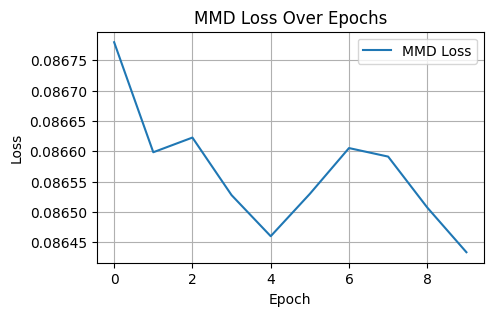

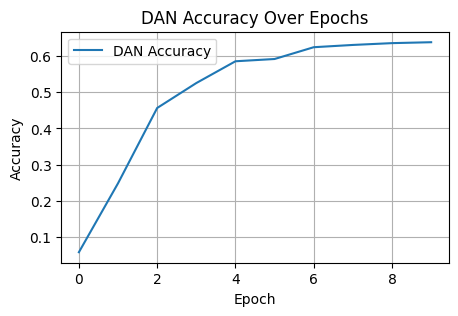

 ---------------------------------------------Running D to A adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 3.6736, Source Accuracy: 0.1076, Target Accuracy: 0.0056
Epoch [2/10], Loss: 2.4223, Source Accuracy: 0.5011, Target Accuracy: 0.0077
Epoch [3/10], Loss: 1.1223, Source Accuracy: 0.8197, Target Accuracy: 0.0042
Epoch [4/10], Loss: 0.7243, Source Accuracy: 0.8891, Target Accuracy: 0.0042
Epoch [5/10], Loss: 0.5794, Source Accuracy: 0.9336, Target Accuracy: 0.0039
Epoch [6/10], Loss: 0.4243, Source Accuracy: 0.9750, Target Accuracy: 0.0049
Epoch [7/10], Loss: 0.3619, Source Accuracy: 0.9902, Target Accuracy: 0.0042
Epoch [8/10], Loss: 0.3593, Source Accuracy: 0.9941, Target Accuracy: 0.0056
Epoch [9/10], Loss: 0.3457, Source Accuracy: 0.9941, Target Accuracy: 0.0063
Epoch [10/10], Loss: 0.3361, Source Accuracy: 0.9980, Target Accuracy: 0.0053
DAN Model Accuracy on the test set: 39.26%


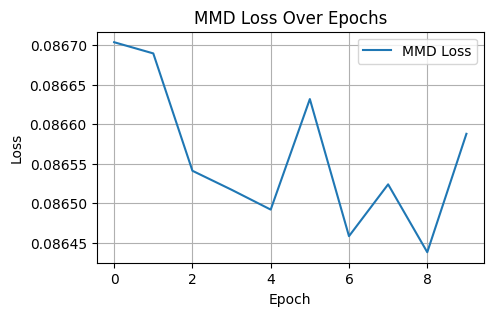

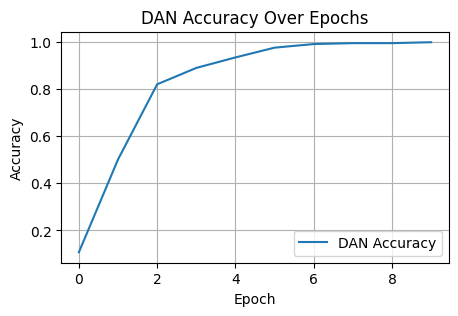

 ---------------------------------------------Running D to W adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 3.6114, Source Accuracy: 0.0792, Target Accuracy: 0.0238
Epoch [2/10], Loss: 2.4291, Source Accuracy: 0.5017, Target Accuracy: 0.0238
Epoch [3/10], Loss: 1.1817, Source Accuracy: 0.7719, Target Accuracy: 0.0200
Epoch [4/10], Loss: 0.6450, Source Accuracy: 0.9130, Target Accuracy: 0.0213
Epoch [5/10], Loss: 0.4834, Source Accuracy: 0.9497, Target Accuracy: 0.0225
Epoch [6/10], Loss: 0.4254, Source Accuracy: 0.9692, Target Accuracy: 0.0225
Epoch [7/10], Loss: 0.3884, Source Accuracy: 0.9844, Target Accuracy: 0.0163
Epoch [8/10], Loss: 0.3419, Source Accuracy: 0.9980, Target Accuracy: 0.0250
Epoch [9/10], Loss: 0.3425, Source Accuracy: 0.9961, Target Accuracy: 0.0312
Epoch [10/10], Loss: 0.3370, Source Accuracy: 0.9980, Target Accuracy: 0.0225
DAN Model Accuracy on the test set: 93.21%


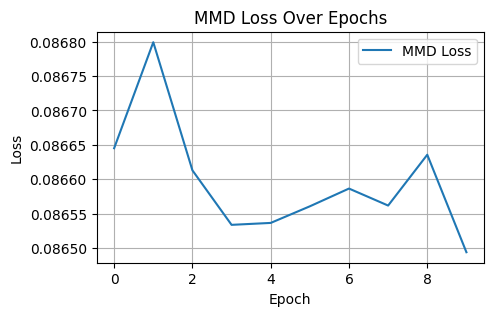

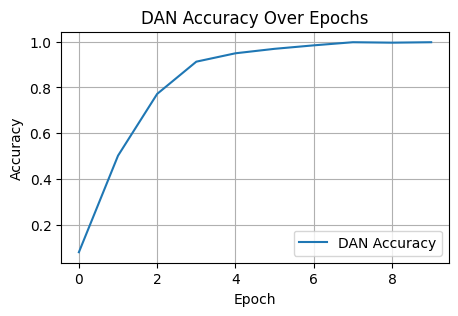

{('A', 'W'): 51.44654088050314, ('A', 'D'): 50.602409638554214, ('W', 'A'): 39.261625843095494, ('W', 'D'): 97.59036144578313, ('D', 'A'): 39.261625843095494, ('D', 'W'): 93.20754716981132}


In [144]:
# Learning rate scheduler based on "inv" policy
def inv_lr_scheduler(optimizer, gamma=0.001, power=0.75, base_lr=0.001):
    def lr_lambda(current_step):
        return (1 + gamma * current_step) ** -power
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


class MKMMDLoss(nn.Module):
    def __init__(self, kernel_scales, lambda_param=1.0, epsilon=1e-3):
        """
        MK-MMD Loss for domain adaptation.

        Args:
            kernel_scales (list of float): Scales (γ) for the Gaussian kernels.
            lambda_param (float): Weight for the MK-MMD regularizer.
            epsilon (float): Small regularizer for quadratic programming.
        """
        super(MKMMDLoss, self).__init__()
        self.kernel_scales = kernel_scales
        self.lambda_param = lambda_param
        self.epsilon = epsilon
        self.beta = None

    def compute_mmd(self, source, target):
        """
        Compute the MK-MMD loss between source and target feature distributions.

        Args:
            source (torch.Tensor): Source domain features of shape (n_s, d).
            target (torch.Tensor): Target domain features of shape (n_t, d).

        Returns:
            torch.Tensor: Scalar MK-MMD loss.
        """
        n_source = source.size(0)
        n_target = target.size(0)
        kernels = []

        device = source.device

        # Initialize self.beta on the correct device
        if self.beta is None:  # Initialize only once in forward pass
            self.beta = nn.Parameter(torch.ones(len(self.kernel_scales)) / len(self.kernel_scales), requires_grad=True).to(device)


        # Compute pairwise distances and apply Gaussian kernels
        for scale in self.kernel_scales:
            kernel_s_s = torch.exp(-torch.cdist(source, source)**2 / scale)
            kernel_t_t = torch.exp(-torch.cdist(target, target)**2 / scale)
            kernel_s_t = torch.exp(-torch.cdist(source, target)**2 / scale)
            kernels.append((kernel_s_s.mean() + kernel_t_t.mean() - 2 * kernel_s_t.mean()))

        # Combine kernels with coefficients
        kernels = torch.stack(kernels).to(device)
        mmd_loss = (self.beta * kernels).sum()
        return mmd_loss

    def forward(self, source_features, target_features):
        """
        Forward pass to compute MK-MMD loss.

        Args:
            source_features (torch.Tensor): Features from source domain.
            target_features (torch.Tensor): Features from target domain.

        Returns:
            torch.Tensor: Scalar MK-MMD loss.
        """
        # Compute the MK-MMD loss
        mmd_loss = self.compute_mmd(source_features, target_features)
        return self.lambda_param * mmd_loss

    def optimize_beta(self, gradients):
        """
        Optimize the kernel coefficients β by solving a quadratic program (QP).

        Args:
            gradients (torch.Tensor): Gradients of kernels w.r.t. β.
        """
        Q = torch.mm(gradients, gradients.T) + self.epsilon * torch.eye(len(gradients)).to(gradients.device)
        d = gradients.sum(dim=1)

        # Quadratic programming to update β (simple torch optimization as an approximation)
        with torch.no_grad():
            beta_new = torch.linalg.solve(Q, d)
            self.beta.data = F.softmax(beta_new, dim=0)  # Normalize to ensure valid β



def init_alexnet_model(numclasses=31):
    """Create a AlexNet model and freeze its initial layers, finetune the rest layers for domain adaptation."""
    model = models.alexnet(pretrained=True)
    # Freeze conv1–conv3
    for name, param in model.features[:6].named_parameters():
        param.requires_grad = False

    # Fine-tune conv4–conv5 and fc layers
    for name, param in model.features[6:].named_parameters():
        param.requires_grad = True
    for name, param in model.classifier[:6].named_parameters():
        param.requires_grad = True

    # Adjust the classifier for num_of_classes
    model.classifier[6] = nn.Linear(4096, numclasses)  # Update number of classes as per dataset
    return model


class DAN(nn.Module):  # Define the Deep Adaptation Network building on AlexNet
    def __init__(self, num_classes, is_grayscale=False):
        super(DAN, self).__init__()
        alexnet = init_alexnet_model(num_classes)
        self.features = alexnet.features
        self.fc6 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.fc7 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.fc8_source = nn.Linear(4096, num_classes)
        self.fc8_target = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc6(x)
        fc7_features = self.fc7(x)
        source_logits = self.fc8_source(fc7_features)
        target_logits = self.fc8_target(fc7_features)
        return fc7_features, source_logits, target_logits



def train_dan_model(model, source_train_loader, target_train_loader, mmd_loss_fn, lambda_mmd, num_epochs, batch_size, learning_rate, beta_init=None):
    """
    Train the DAN model with MK-MMD loss and fine-tuning.

    Arguments:
    - model: The DAN model (e.g., AlexNet-based model with final classifier layer).
    - source_train_loader: DataLoader for source domain training data.
    - target_train_loader: DataLoader for target domain training data.
    - source_val_loader: DataLoader for source domain validation data.
    - target_val_loader: DataLoader for target domain validation data.
    - mmd_loss_fn: The MK-MMD loss function object.
    - lambda_mmd: The penalty parameter lambda for MMD loss.
    - num_epochs: Number of epochs to train.
    - batch_size: The batch size for the training process.
    - learning_rate: Learning rate for SGD optimizer.
    - beta_init: Initial weights for the multi-kernel MMD. Defaults to None if not provided.

    Returns:
    - model: The trained model.
    """

    # Define the optimizer for the model (using SGD with momentum)
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.SGD([
        {'params': model.features.parameters(), 'lr': learning_rate},  # Features
        {'params': model.fc6.parameters(), 'lr': learning_rate},        # Fully connected 6
        {'params': model.fc7.parameters(), 'lr': learning_rate},        # Fully connected 7
        {'params': model.fc8_source.parameters(), 'lr': learning_rate * 10},  # Source classifier
        {'params': model.fc8_target.parameters(), 'lr': learning_rate * 10},  # Target classifier
    ], momentum=0.9)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  #gives 52% a stepsize 7, gamma 0.1
    # scheduler = inv_lr_scheduler(optimizer, gamma=0.1, power=0.75, base_lr=learning_rate)  #gamma=0.1 gave 50%TESTacc


    # Training loop
    mmd_losses = []
    dan_accs = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_source_accuracy = 0
        total_target_accuracy = 0

        for (source_data, source_labels), (target_data, target_labels) in zip(source_train_loader, target_train_loader):
            # Move data to GPU if available
            source_data, source_labels = source_data.cuda(), source_labels.cuda()
            target_data, target_labels = target_data.cuda(), target_labels.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: source and target domain
            source_features, source_logits, _ = model(source_data)
            target_features , _ , target_logits  = model(target_data)

            # Compute classification loss for the source domain (cross-entropy)
            classification_loss = F.cross_entropy(source_logits, source_labels)

            # Compute MK-MMD loss
            mmd_loss = mmd_loss_fn(source_features, target_features)


            # Combine losses: classification loss + regularization (MMD loss)
            loss = classification_loss + lambda_mmd * mmd_loss
            total_loss += loss.item()

            # Backpropagate gradients
            loss.backward()
            optimizer.step()

            # Calculate accuracy for source and target domains (for monitoring)
            source_preds = source_logits.argmax(dim=1)
            source_accuracy = accuracy_score(source_labels.cpu(), source_preds.cpu())
            total_source_accuracy += source_accuracy

            # Use target data for validation purposes only
            target_preds = target_logits.argmax(dim=1)
            target_accuracy = accuracy_score(target_labels.cpu(), target_preds.cpu())
            total_target_accuracy += target_accuracy



        scheduler.step()
        mmd_losses.append(mmd_loss.item())

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(source_train_loader)
        avg_source_accuracy = total_source_accuracy / len(source_train_loader)
        avg_target_accuracy = total_target_accuracy / len(target_train_loader)
        dan_accs.append(avg_source_accuracy)

        # Print out the progress
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Source Accuracy: {avg_source_accuracy:.4f}, Target Accuracy: {avg_target_accuracy:.4f}")

    return model, mmd_losses, dan_accs

num_epochs=10
dan_accs = []
for i,combo in enumerate(office31_combos):
    # if i!=4:
    #   continue
    source_train_loader = combo[0]
    target_train_loader = combo[1]


    src_name = office31_combo_names[i][0]
    tgt_name = office31_combo_names[i][1]
    print(f" ---------------------------------------------Running {src_name} to {tgt_name} adaptation")

    # Create the MK-MMD loss function with a set of kernel scales and initialize the model
    model = DAN(num_classes=31).cuda()
    kernel_scales = [2**i for i in range(-8, 9)]  # Example: use powers of 2 for gamma values
    mmd_loss_fn = MKMMDLoss(kernel_scales=kernel_scales, lambda_param=1.0).cuda()


    # Hyperparameters
    lambda_mmd = 5.0  # Regularization parameter for MMD loss  ... all values (0.005 -> 50) gives 52% test acc
    # gamma = 1.0  # Gaussian kernel bandwidth (not directly used in this function)
    # beta_init = None  # Optionally initialize beta for MMD (uniform initialization by default)


    trained_dan_model, mmd_losses, dan_accs  = train_dan_model(
        model=model,
        source_train_loader=source_train_loader,
        target_train_loader=target_train_loader,
        mmd_loss_fn=mmd_loss_fn,
        lambda_mmd=lambda_mmd,
        num_epochs=num_epochs,
        batch_size=target_train_loader.batch_size,
        learning_rate=learning_rate
    )


    dan_acc = evaluate_accuracy(trained_dan_model, target_train_loader, device, "DAN")
    office31_combo_accs['dan'][(src_name,tgt_name)] = dan_acc
    # dan_accs.append(dan_acc)

    plt.figure(figsize=(5, 3))

    plt.plot(mmd_losses, label='MMD Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('MMD Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(5, 3))
    plt.plot(dan_accs, label='DAN Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('DAN Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.show()

    # continue

    if i==0:
      visualize_feature_distributions(trained_dan_model, source_train_loader, target_train_loader, device)



print(office31_combo_accs['dan'])
dan_office31_accs = office31_combo_accs['dan']
office31_accs.append(dan_office31_accs)

In [146]:
kernel_scales

[0.00390625,
 0.0078125,
 0.015625,
 0.03125,
 0.0625,
 0.125,
 0.25,
 0.5,
 1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 256]

In [106]:
def visualize_feature_distributions_resnet(model, source_loader, target_loader, device):
    def get_features(resnet,x):
      features = resnet.avgpool(resnet.layer4(resnet.layer3(resnet.layer2(resnet.layer1(resnet.relu(resnet.bn1(resnet.conv1(x))))))))
      features = torch.flatten(features, 1)
      return features

    model.eval()
    source_features, source_labels = [], []
    target_features, target_labels = [], []

    # Extract source features
    with torch.no_grad():
        for data, labels in source_loader:
            data = data.to(device)
            features =  get_features(model,data)
            source_features.append(features.cpu().numpy())
            source_labels.extend(labels.numpy())

    # Extract target features
    with torch.no_grad():
        for data, labels in target_loader:
            data = data.to(device)
            features = get_features(model,data)
            target_features.append(features.cpu().numpy())
            target_labels.extend(labels.numpy())

    # Combine and reduce dimensions using t-SNE
    all_features = np.concatenate([np.vstack(source_features), np.vstack(target_features)], axis=0)
    all_labels = np.array(source_labels + target_labels)
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(all_features)

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(
        reduced_features[:len(source_labels), 0], reduced_features[:len(source_labels), 1],
        c=source_labels, cmap='viridis', label='Source Domain', alpha=0.6
    )
    plt.scatter(
        reduced_features[len(source_labels):, 0], reduced_features[len(source_labels):, 1],
        c=target_labels, cmap='plasma', label='Target Domain', alpha=0.6
    )
    plt.title("t-SNE Visualization of Feature Distributions for ResNet")
    plt.legend()
    plt.show()

# Run visualization for one of the domain pairs as an example
# source_train_loader, target_train_loader = office31_combos[len(office31_combos)-1]  # Select one pair
# visualize_feature_distributions(resnet, source_train_loader, target_train_loader, device)

In [126]:
# perf_resnet

[(78.84274050408236, 65.53459119496856, 13.308149309113801),
 (76.49982250621228, 61.24497991967871, 15.25484258653357),
 (52.704402515723274, 17.64288249911253, 35.06152001661074),
 (52.83018867924528, 35.94377510040161, 16.886413578843673),
 (40.963855421686745, 15.157969471068512, 25.805885950618233),
 (42.16867469879518, 25.031446540880502, 17.137228157914677)]

---------------------------------------------Running D to A adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finetuning ResNet baseline model to source domain
Epoch [1/1], Loss: 3.2912
ResNet Model Accuracy on the test set: 41.57%
ResNet Model Accuracy on the test set: 14.48%


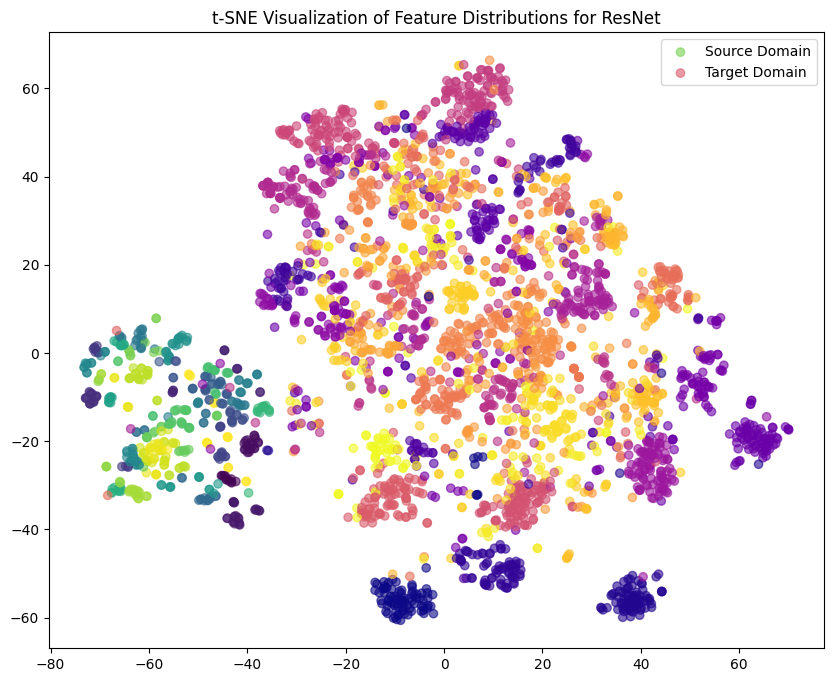

{('A', 'W'): 0.0, ('A', 'D'): 0.0, ('W', 'A'): 37.912673056443026, ('W', 'D'): 32.1285140562249, ('D', 'A'): 14.48349307774228, ('D', 'W'): 24.528301886792452}


In [132]:

for i,combo in enumerate(office31_combos):
    if i!=4:
      continue
    source_train_loader = combo[0]
    target_train_loader = combo[1]

    src_name = office31_combo_names[i][0]
    tgt_name = office31_combo_names[i][1]
    print(f"---------------------------------------------Running {src_name} to {tgt_name} adaptation")

    resnet = init_resnet(num_classes=31).cuda()
    finetune_baseline_model(resnet, source_train_loader, device, learning_rate, 1)

    # Evaluate on source and target datasets
    source_acc = evaluate_accuracy(resnet, source_train_loader, device, f"ResNet")
    target_acc = evaluate_accuracy(resnet, target_train_loader, device, f"ResNet")
    office31_combo_accs['resnet'][(src_name,tgt_name)] = target_acc

    if i==4:
      visualize_feature_distributions_resnet(resnet, source_train_loader, target_train_loader, device)

print(office31_combo_accs['resnet'])
resnet_office31_accs = office31_combo_accs['resnet']
office31_accs.append(resnet_office31_accs)

---------------------------------------------Running A to W adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finetuning ResNet baseline model to source domain
Epoch [1/1], Loss: 2.4977
ResNet Model Accuracy on the test set: 78.84%
ResNet Model Accuracy on the test set: 65.53%


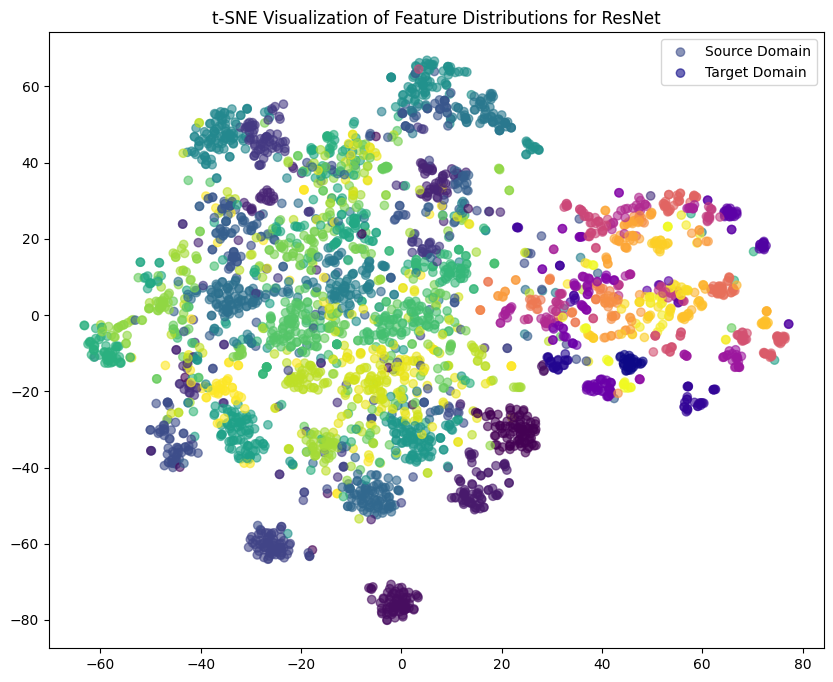

---------------------------------------------Running A to D adaptation


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finetuning ResNet baseline model to source domain
Epoch [1/1], Loss: 2.5105
ResNet Model Accuracy on the test set: 76.50%
ResNet Model Accuracy on the test set: 61.24%
---------------------------------------------Running W to A adaptation
Finetuning ResNet baseline model to source domain
Epoch [1/1], Loss: 3.2309
ResNet Model Accuracy on the test set: 52.70%
ResNet Model Accuracy on the test set: 17.64%
---------------------------------------------Running W to D adaptation
Finetuning ResNet baseline model to source domain
Epoch [1/1], Loss: 3.1970
ResNet Model Accuracy on the test set: 52.83%
ResNet Model Accuracy on the test set: 35.94%
---------------------------------------------Running D to A adaptation
Finetuning ResNet baseline model to source domain
Epoch [1/1], Loss: 3.2978
ResNet Model Accuracy on the test set: 40.96%
ResNet Model Accuracy on the test set: 15.16%
---------------------------------------------Running D to W adaptation
Finetuning ResNet baseline model to source d

In [111]:
perf_resnet = []
for i,combo in enumerate(office31_combos):
    source_train_loader = combo[0]
    target_train_loader = combo[1]

    src_name = office31_combo_names[i][0]
    tgt_name = office31_combo_names[i][1]
    print(f"---------------------------------------------Running {src_name} to {tgt_name} adaptation")

    resnet = init_resnet(num_classes=31).cuda()
    finetune_baseline_model(resnet, source_train_loader, device, learning_rate, num_epochs)

    # Evaluate on source and target datasets
    source_acc = evaluate_accuracy(resnet, source_train_loader, device, f"ResNet")
    target_acc = evaluate_accuracy(resnet, target_train_loader, device, f"ResNet")
    perf_resnet.append((source_acc, target_acc, source_acc - target_acc))
    office31_combo_accs['resnet'][(src_name,tgt_name)] = target_acc

    if i==0:
      visualize_feature_distributions_resnet(resnet, source_train_loader, target_train_loader, device)

print(office31_combo_accs['resnet'])
resnet_office31_accs = office31_combo_accs['resnet']
office31_accs.append(resnet_office31_accs)

In [112]:
def visualize_feature_distributions_dann(model, source_loader, target_loader, device, lamda):
    def get_features(model, x, lamda):
        feature = model.feature_extractor(x)
        feature = feature.view(-1, 50 * 7 * 7)
        reverse_feature = ReverseLayer.apply(feature, lamda)
        return reverse_feature

    model.eval()
    source_features, source_labels = [], []
    target_features, target_labels = [], []

    # Extract source features
    with torch.no_grad():
        for data, labels in source_loader:
            data = data.to(device)
            features = get_features(model, data, lamda)
            source_features.append(features.cpu().numpy())
            source_labels.extend(labels.numpy())

    # Extract target features
    with torch.no_grad():
        for data, labels in target_loader:
            data = data.to(device)
            features = get_features(model, data, lamda)
            target_features.append(features.cpu().numpy())
            target_labels.extend(labels.numpy())

    # Combine and reduce dimensions using t-SNE
    all_features = np.concatenate([np.vstack(source_features), np.vstack(target_features)], axis=0)
    all_labels = np.array(source_labels + target_labels)
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(all_features)

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(
        reduced_features[:len(source_labels), 0], reduced_features[:len(source_labels), 1],
        c=source_labels, cmap='viridis', label='Source Domain', alpha=0.6
    )
    plt.scatter(
        reduced_features[len(source_labels):, 0], reduced_features[len(source_labels):, 1],
        c=target_labels, cmap='plasma', label='Target Domain', alpha=0.6
    )
    plt.title("t-SNE Visualization of Feature Distributions for DANN")
    plt.legend()
    plt.show()


---------------------------------------------Running A to W adaptation


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/10], Total Loss: 121.456404	Source Classification Loss: 85.879270	 Overall Domain Loss: 35.577133
Epoch [2/10], Total Loss: 114.364443	Source Classification Loss: 79.762523	 Overall Domain Loss: 34.601921
Epoch [3/10], Total Loss: 113.101289	Source Classification Loss: 78.872316	 Overall Domain Loss: 34.228973
Epoch [4/10], Total Loss: 109.089740	Source Classification Loss: 75.120274	 Overall Domain Loss: 33.969466
Epoch [5/10], Total Loss: 106.780336	Source Classification Loss: 73.871329	 Overall Domain Loss: 32.909008
Epoch [6/10], Total Loss: 103.182214	Source Classification Loss: 71.607439	 Overall Domain Loss: 31.574773
Epoch [7/10], Total Loss: 102.851963	Source Classification Loss: 73.016415	 Overall Domain Loss: 29.835547
Epoch [8/10], Total Loss: 96.546649	Source Classification Loss: 69.694293	 Overall Domain Loss: 26.852355
Epoch [9/10], Total Loss: 93.327008	Source Classification Loss: 69.324268	 Overall Domain Loss: 24.002741
Epoch [10/10], Total Loss: 90.864067	So

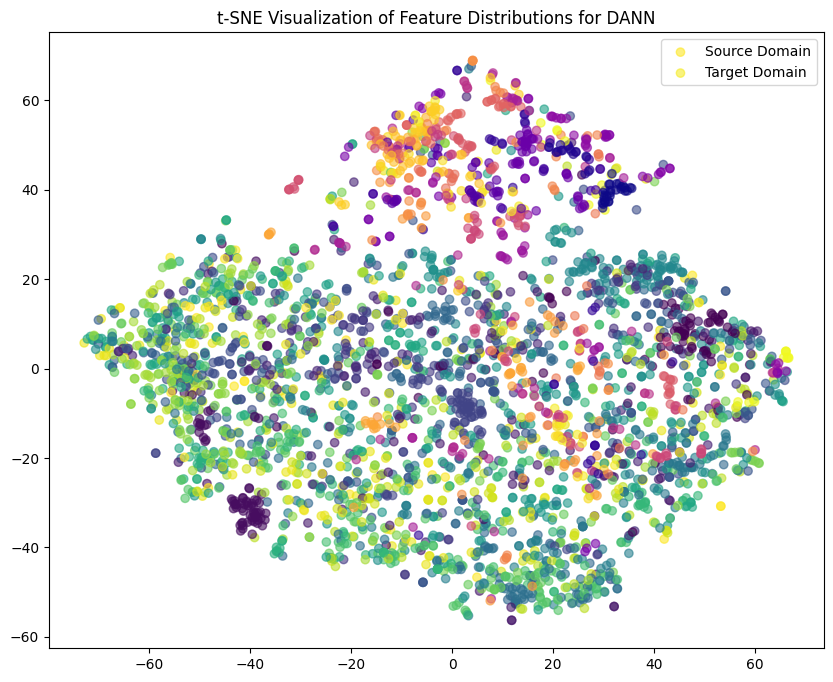

---------------------------------------------Running A to D adaptation


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/10], Total Loss: 79.471052	Source Classification Loss: 56.421024	 Overall Domain Loss: 23.050028
Epoch [2/10], Total Loss: 75.210477	Source Classification Loss: 53.014860	 Overall Domain Loss: 22.195618
Epoch [3/10], Total Loss: 72.766860	Source Classification Loss: 50.611201	 Overall Domain Loss: 22.155659
Epoch [4/10], Total Loss: 71.801705	Source Classification Loss: 49.660488	 Overall Domain Loss: 22.141218
Epoch [5/10], Total Loss: 70.753394	Source Classification Loss: 48.676280	 Overall Domain Loss: 22.077114
Epoch [6/10], Total Loss: 68.944069	Source Classification Loss: 46.977256	 Overall Domain Loss: 21.966814
Epoch [7/10], Total Loss: 68.792022	Source Classification Loss: 46.907123	 Overall Domain Loss: 21.884900
Epoch [8/10], Total Loss: 67.862899	Source Classification Loss: 46.098942	 Overall Domain Loss: 21.763956
Epoch [9/10], Total Loss: 66.769241	Source Classification Loss: 45.126032	 Overall Domain Loss: 21.643209
Epoch [10/10], Total Loss: 64.503517	Source Cl

In [145]:
class DANN(nn.Module):

    def __init__(self, num_classes):
        super(DANN, self).__init__()
        # Construct DANNet architecture
        # self.feature_extractor = nn.Sequential()
        # self.feature_extractor.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        # self.feature_extractor.add_module('f_bn1', nn.BatchNorm2d(64))
        # self.feature_extractor.add_module('f_pool1', nn.MaxPool2d(2))
        # self.feature_extractor.add_module('f_relu1', nn.ReLU(True))
        # self.feature_extractor.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        # self.feature_extractor.add_module('f_bn2', nn.BatchNorm2d(50))
        # self.feature_extractor.add_module('f_drop1', nn.Dropout2d())
        # self.feature_extractor.add_module('f_pool2', nn.MaxPool2d(2))
        # self.feature_extractor.add_module('f_relu2', nn.ReLU(True))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),  # Output size: [batch, 64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),  # Output size: [batch, 64, 56, 56]

            nn.Conv2d(64, 50, kernel_size=5, stride=2, padding=2),  # Output size: [batch, 50, 28, 28]
            nn.BatchNorm2d(50),
            nn.ReLU(True),
            nn.Dropout2d(),
            nn.MaxPool2d(2),  # Output size: [batch, 50, 14, 14]

            nn.Conv2d(50, 50, kernel_size=3, stride=1, padding=1),  # Output size: [batch, 50, 14, 14] (no change in spatial size)
            nn.BatchNorm2d(50),
            nn.ReLU(True),
            nn.MaxPool2d(2)  # Output size: [batch, 50, 7, 7]
        )


        self.label_predictor = nn.Sequential()
        self.label_predictor.add_module('c_fc1', nn.Linear(50 * 7 * 7, 100))
        self.label_predictor.add_module('c_bn1', nn.BatchNorm1d(100))
        self.label_predictor.add_module('c_relu1', nn.ReLU(True))
        self.label_predictor.add_module('c_drop1', nn.Dropout2d())
        self.label_predictor.add_module('c_fc2', nn.Linear(100, 100))
        self.label_predictor.add_module('c_bn2', nn.BatchNorm1d(100))
        self.label_predictor.add_module('c_relu2', nn.ReLU(True))
        self.label_predictor.add_module('c_fc3', nn.Linear(100, num_classes))
        self.label_predictor.add_module('c_softmax', nn.LogSoftmax(dim=1))

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(50 * 7 * 7, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input, lamda):
        input = input.cuda()
        feature = self.feature_extractor(input)
        feature = feature.view(-1, 50 * 7 * 7)
        reverse_feature = ReverseLayer.apply(feature, lamda)
        class_prediction = self.label_predictor(feature)
        domain_prediction = self.domain_classifier(reverse_feature)
        return class_prediction, domain_prediction


class ReverseLayer(Function):

    @staticmethod
    def forward(ctx, x, lamda):
        ctx.lamda = lamda
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lamda
        return output, None



def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    - optimizer: optimizer for updating parameters
    - p: a variable for adjusting learning rate
    return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer


def train_dann_model(net, source_dataloader, target_dataloader, num_epochs, gamma, device):

    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    for param in net.parameters():
        param.requires_grad = True


    class_loss = nn.NLLLoss()
    domain_loss = nn.NLLLoss()
    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    num_tgt_batches, num_src_batches = len(target_dataloader), len(source_dataloader)
    total_batches = num_tgt_batches + num_src_batches


    for epoch in range(num_epochs):
      net.train()
      epoch_loss, epoch_source_class_error, epoch_domain_error  = 0.0, 0.0, 0.0
      for batch_idx, (source, target) in enumerate(zip(source_dataloader, target_dataloader)):

          # Setup hyperparameters, optimizer
          p = (batch_idx + epoch * len_dataloader) / (num_epochs * len_dataloader)
          lamda = 2. / (1. + np.exp(gamma * p)) - 1
          optimizer = optimizer_scheduler(optimizer, p)
          optimizer.zero_grad()

          # Get the source and target data
          source_input, source_label = source
          target_input, target_label = target

          # source_input, source_label = source_input.to(device), source_label.to(device)
          # target_input, target_label = target_input.to(device), target_label.to(device)

          # # Predictions
          # source_label_pred, source_domain_pred = net(source_input, lamda)
          # _, target_domain_pred = net(target_input, lamda)

          # # Define source and target domain labels
          # source_labels = torch.zeros(source_input.size(0), dtype=torch.long).to(device)
          # target_labels = torch.ones(target_input.size(0), dtype=torch.long).to(device)

          # # Compute losses
          # source_class_error = class_loss(source_label_pred, source_label)
          # source_domain_error = domain_loss(source_domain_pred, source_labels)
          # target_domain_error = domain_loss(target_domain_pred, target_labels)

          # Transfer data to PyTorch tensors
          if device == 'cuda':
              source_input, source_label = Variable(source_input.cuda()), Variable(source_label.cuda())
              target_input, target_label = Variable(target_input.cuda()), Variable(target_label.cuda())
          else:
              source_input, source_label = Variable(source_input), Variable(source_label)
              target_input, target_label = Variable(target_input), Variable(target_label)

          # Define source and target predicted labels
          if device == 'cuda':
              source_labels = Variable(torch.zeros((source_input.size()[0])).type(torch.LongTensor).cuda())
              target_labels = Variable(torch.ones((target_input.size()[0])).type(torch.LongTensor).cuda())
          else:
              source_labels = Variable(torch.zeros((source_input.size()[0])).type(torch.LongTensor))
              target_labels = Variable(torch.ones((target_input.size()[0])).type(torch.LongTensor))

          # Train model using source data
          source_label_pred, source_domain_pred = net(source_input, lamda)
          source_class_error = class_loss(source_label_pred, source_label)
          source_domain_error = domain_loss(source_domain_pred, source_labels)
          # Train model using target data
          _, target_domain_pred = net(target_input, lamda)
          target_domain_error = domain_loss(target_domain_pred, target_labels)

          # Compute loss and backprop
          domain_error = source_domain_error + target_domain_error
          loss = source_class_error + domain_error
          loss.backward()
          optimizer.step()

          # Accumulate the losses over the epoch
          epoch_loss += loss.item()
          epoch_source_class_error += source_class_error.item()
          epoch_domain_error += domain_error.item()

          # if (batch_idx + 1) % 10 == 0:
          #     print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tClass Loss: {:.6f}\tDomain Loss: {:.6f}'.format(
          #         batch_idx * len(target_input), len(target_dataloader.dataset),
          #         100. * batch_idx / len(target_dataloader), loss.item(), source_class_error.item(),
          #         domain_error.item()
          #     ))

      print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {epoch_loss  :.6f}\tSource Classification Loss: {epoch_source_class_error :.6f}\t Overall Domain Loss: {epoch_domain_error :.6f}")

    return net

def test_dann_model(net, source_dataloader, target_dataloader, device):

    net.eval()
    source_label_correct, target_label_correct =  0.0, 0.0
    source_domain_correct, target_domain_correct, domain_correct = 0.0, 0.0, 0.0

    for batch_idx, source_data in enumerate(source_dataloader):
        # Setup hyperparameters and input data
        p = float(batch_idx) / len(source_dataloader)
        lamda = 2. / (1. + np.exp(-10 * p)) - 1.
        source_input, source_label = source_data

        # Transfer data to PyTorch tensor and define PyTorch Variable for source predicted labels
        if device == 'cuda':
            source_input, source_label = Variable(source_input.cuda()), Variable(source_label.cuda())
            source_labels = Variable(torch.zeros((source_input.size()[0])).type(torch.LongTensor).cuda())
        else:
            source_input, source_label = Variable(source_input), Variable(source_label)
            source_labels = Variable(torch.zeros((source_input.size()[0])).type(torch.LongTensor))

        # Compute source accuracy both for label and domain predictions
        source_label_pred, source_domain_pred = net(source_input, lamda)
        source_label_pred = source_label_pred.data.max(1, keepdim = True)[1]
        source_label_correct += source_label_pred.eq(source_label.data.view_as(source_label_pred)).cpu().sum()
        source_domain_pred = source_domain_pred.data.max(1, keepdim=True)[1]
        source_domain_correct += source_domain_pred.eq(source_labels.data.view_as(source_domain_pred)).cpu().sum()

    # Test target data
    for batch_idx, target_data in enumerate(target_dataloader):
        # Setup hyperparameters and input data
        p = float(batch_idx) / len(target_dataloader)
        lamda = 2. / (1. + np.exp(-10 * p)) - 1.
        target_input, target_label = source_data

        # Transfer data to PyTorch tensor and define PyTorch Variable for target predicted labels
        if device == 'cuda':
            target_input, target_label = Variable(target_input.cuda()), Variable(target_label.cuda())
            target_labels = Variable(torch.zeros((target_input.size()[0])).type(torch.LongTensor).cuda())
        else:
            target_input, target_label = Variable(target_input), Variable(target_label)
            target_labels = Variable(torch.zeros((target_input.size()[0])).type(torch.LongTensor))

        # Compute target accuracy both for label and domain predictions
        target_label_pred, target_domain_pred = net(target_input, lamda)
        target_label_pred = target_label_pred.data.max(1, keepdim=True)[1]
        target_label_correct += target_label_pred.eq(target_label.data.view_as(target_label_pred)).cpu().sum()
        target_domain_pred = target_domain_pred.data.max(1, keepdim=True)[1]
        target_domain_correct += target_domain_pred.eq(target_labels.data.view_as(target_domain_pred)).cpu().sum()

    # Compute domain correctness
    domain_correct = source_domain_correct + target_domain_correct
    print('\nSource Accuracy: {}/{} ({:.4f}%)\nTarget Accuracy: {}/{} ({:.4f}%)\n'
          'Domain Accuracy: {}/{} ({:.4f}%)\n'.
        format(
        source_label_correct, len(source_dataloader.dataset),
        100. * float(source_label_correct) / len(source_dataloader.dataset),
        target_label_correct, len(target_dataloader.dataset),
        100. * float(target_label_correct) / len(target_dataloader.dataset),
        domain_correct, len(source_dataloader.dataset) + len(target_dataloader.dataset),
                                                        100. * float(domain_correct) / (
                                                                    len(source_dataloader.dataset) + len(
                                                                target_dataloader.dataset))
    ))

    t_acc = 100. * float(target_label_correct) / len(target_dataloader.dataset)
    s_acc = 100. * float(source_label_correct) / len(source_dataloader.dataset)
    domain_acc = 100. * float(domain_correct) / (len(source_dataloader.dataset) + len(target_dataloader.dataset))

    return t_acc + s_acc + domain_acc


# test_dann_model(trained_dann_model, amazon_loader, webcam_loader, device)
# dann_acc = evaluate_accuracy(trained_dann_model, webcam_loader, device, "DANN")
# 48, 0, 43 [30_epochs] ---> domain acc decreases after 30 epochs --->  54, 3, 20 [45_epochs]

dann_accs = []
for i,combo in enumerate(office31_combos):
    # if i!=4:
    #   continue
    source_train_loader = combo[0]
    target_train_loader = combo[1]

    src_name = office31_combo_names[i][0]
    tgt_name = office31_combo_names[i][1]
    print(f"---------------------------------------------Running {src_name} to {tgt_name} adaptation")
    gamma = 10                # https://github.com/PanPapag/DANN/blob/master/main.py
    net = DANN(num_classes=31)
    device = 'cuda'
    trained_dann_model = train_dann_model(net, source_train_loader, target_train_loader, num_epochs, gamma, device)
    dann_acc = test_dann_model(trained_dann_model, source_train_loader, target_train_loader, device)
    dann_accs.append(dann_acc)
    if i==0:
      visualize_feature_distributions_dann(trained_dann_model, source_train_loader, target_train_loader, device, gamma)
    # dann_acc = evaluate_accuracy(trained_dann_model, webcam_loader, device, "DANN")

    office31_combo_accs['dann'][(src_name,tgt_name)] = dann_acc

print(office31_combo_accs['dann'])
dann_office31_accs = office31_combo_accs['dann']
office31_accs.append(dann_office31_accs)


In [129]:
dann_accs

[0.0,
 0.0,
 37.912673056443026,
 32.1285140562249,
 25.275115370962016,
 28.30188679245283]

In [55]:
digits_combos = [
    (mnist_loader, svhn_loader),
    (mnist_loader, usps_loader),
    (svhn_loader, mnist_loader),
    (svhn_loader, usps_loader),
    (usps_loader, mnist_loader),
    (usps_loader, svhn_loader)
]

digits_acc_dict = {
    ('M','S'):0 ,
    ('M','U'):0 ,
    ('S','M'):0 ,
    ('S','U'):0 ,
    ('U','M'):0 ,
    ('U','S'):0
  }

digits_combo_accs = {
  'resnet': digits_acc_dict,
  'dan': digits_acc_dict,
  'dann': digits_acc_dict
}

digits_combo_names = list(digits_acc_dict.keys())

digits_accs = []

In [80]:
# Print the shape of one batch from MNIST loader
mnist_batch = next(iter(mnist_loader))
mnist_images, mnist_labels = mnist_batch
print(f"MNIST batch image shape: {mnist_images.shape}, label shape: {mnist_labels.shape}")

# Print the shape of one batch from SVHN loader
svhn_batch = next(iter(svhn_loader))
svhn_images, svhn_labels = svhn_batch
print(f"SVHN batch image shape: {svhn_images.shape}, label shape: {svhn_labels.shape}")

# Print the shape of one batch from USPS loader
usps_batch = next(iter(usps_loader))
usps_images, usps_labels = usps_batch
print(f"USPS batch image shape: {usps_images.shape}, label shape: {usps_labels.shape}")

MNIST batch image shape: torch.Size([32, 1, 16, 16]), label shape: torch.Size([32])
SVHN batch image shape: torch.Size([32, 1, 16, 16]), label shape: torch.Size([32])
USPS batch image shape: torch.Size([32, 1, 16, 16]), label shape: torch.Size([32])


In [143]:
for i,combo in enumerate(digits_combos):
    source_train_loader = combo[0]
    target_train_loader = combo[1]


    src_name = digits_combo_names[i][0]
    tgt_name = digits_combo_names[i][1]
    print(f" ---------------------------------------------Running {src_name} to {tgt_name} adaptation")

    # Create the MK-MMD loss function with a set of kernel scales and initialize the model
    model = DAN(num_classes=10, is_grayscale=True).cuda()
    kernel_scales = [2**i for i in range(-8, 9)]  # Example: use powers of 2 for gamma values
    mmd_loss_fn = MKMMDLoss(kernel_scales=kernel_scales, lambda_param=1.0).cuda()

    # Hyperparameters
    lambda_mmd = 5.0  # Regularization parameter for MMD loss  ... all values (0.005 -> 50) gives 52% test acc
    # gamma = 1.0  # Gaussian kernel bandwidth (not directly used in this function)
    # beta_init = None  # Optionally initialize beta for MMD (uniform initialization by default)


    trained_dan_model = train_dan_model(
        model=model,
        source_train_loader=source_train_loader,
        target_train_loader=target_train_loader,
        mmd_loss_fn=mmd_loss_fn,
        lambda_mmd=lambda_mmd,
        num_epochs=num_epochs,
        batch_size=target_train_loader.batch_size,
        learning_rate=learning_rate
    )
    dan_acc = evaluate_accuracy(trained_dan_model, target_train_loader, device, "DAN")
    digits_combo_accs['dan'][(src_name,tgt_name)] = dan_acc

# print(digits_combo_accs['dan'])
dan_digits_accs = digits_combo_accs['dan']
digits_accs.append(dan_digits_accs)


  ---------------------------------------------Running M to S adaptation
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch [1/10], Loss: 3.6342, Source Accuracy: 0.0998, Target Accuracy: 0.0067
Epoch [2/10], Loss: 2.4457, Source Accuracy: 0.4961, Target Accuracy: 0.0063
Epoch [3/10], Loss: 1.1021, Source Accuracy: 0.8192, Target Accuracy: 0.0039
Epoch [4/10], Loss: 0.6460, Source Accuracy: 0.9106, Target Accuracy: 0.004

In [142]:
for i,combo in enumerate(digits_combos):
    source_train_loader = combo[0]
    target_train_loader = combo[1]

    src_name = digits_combo_names[i][0]
    tgt_name = digits_combo_names[i][1]
    print(f"---------------------------------------------Running {src_name} to {tgt_name} adaptation")

    resnet = init_resnet(num_classes=10).cuda()
    finetune_baseline_model(resnet, source_train_loader, device, learning_rate, num_epochs)
    resnet_acc = evaluate_accuracy(resnet, target_train_loader, device, "ResNet")
    digits_combo_accs['resnet'][(src_name,tgt_name)] = resnet_acc

# print(digits_combo_accs['resnet'])
resnet_digits_accs = digits_combo_accs['resnet']
digits_accs.append(resnet_digits_accs)


---------------------------------------------Running M to S adaptation
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Finetuning ResNet baseline model to source domain
Epoch [1/1], Loss: 2.4977
ResNet Model Accuracy on the test set: 78.84%
ResNet Model Accuracy on the test set: 65.53%


In [141]:
test_dann_model(trained_dann_model, amazon_loader, webcam_loader, device)
dann_acc = evaluate_accuracy(trained_dann_model, webcam_loader, device, "DANN")
48, 0, 43 [30_epochs] ---> domain acc decreases after 30 epochs --->  54, 3, 20 [45_epochs]

for i,combo in enumerate(digits_combos):
    source_train_loader = combo[0]
    target_train_loader = combo[1]

    src_name = digits_combo_names[i][0]
    tgt_name = digits_combo_names[i][1]
    print(f"---------------------------------------------Running {src_name} to {tgt_name} adaptation")
    gamma = 10
    net = DANN(num_classes=10)
    device = 'cuda'
    trained_dann_model = train_dann_model(net, source_train_loader, target_train_loader, num_epochs, gamma, device)
    dann_acc = test_dann_model(trained_dann_model, source_train_loader, target_train_loader, device)
    # dann_acc = evaluate_accuracy(trained_dann_model, webcam_loader, device, "DANN")


    digits_combo_accs['dann'][(src_name,tgt_name)] = dann_acc

# print(digits_combo_accs['dann'])
dann_digits_accs = digits_combo_accs['dann']
digits_accs.append(dann_digits_accs)


 
---------------------------------------------Running M to S adaptation
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch [1/10], Total Loss: 76.968413	Source Classification Loss: 53.767589	 Overall Domain Loss: 23.200824
Epoch [2/10], Total Loss: 68.919808	Source Classification Loss: 46.736573	 Overall Domain Loss: 22.183236
Epoch [3/10], Total Loss: 64.850714	Source Classification Loss: 42.979129	 Overall Domain Loss: 21.871584
Epoch [4/10], Total Loss: 61.274339	Source Classification Loss: 39.593836	 Overall Domain Loss: 21.680503
Epoch [5/10], Total Loss: 57.9